In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [72]:

df = pd.read_csv("dataset.csv", sep=";").replace(",", ".", regex=True)
df = df.astype({col: "float" for col in df.columns[1:-1]})  
df.head()

,Context,F1_Central,F1_Mean,F1_F1max,F1_Ampmax,F2_Central,F2_Mean,F2_F1max,F2_Ampmax,Label
0,kced,482.0,492.000000,508.0,482.0,1875.0,1896.692308,1942.0,1875.0,E
1,kched,508.0,486.777778,508.0,499.0,1827.0,1829.166667,1962.0,1875.0,E
2,kbeb,499.0,504.647059,521.0,499.0,1671.0,1630.588235,1680.0,1680.0,E
3,kbed,499.0,496.421053,508.0,508.0,1747.0,1708.789474,1751.0,1732.0,E
4,kbeg,508.0,494.600000,508.0,508.0,1632.0,1669.333333,1845.0,1602.0,E


In [73]:
df = df.drop(columns= 'Context')
df.head()


,F1_Central,F1_Mean,F1_F1max,F1_Ampmax,F2_Central,F2_Mean,F2_F1max,F2_Ampmax,Label
0,482.0,492.000000,508.0,482.0,1875.0,1896.692308,1942.0,1875.0,E
1,508.0,486.777778,508.0,499.0,1827.0,1829.166667,1962.0,1875.0,E
2,499.0,504.647059,521.0,499.0,1671.0,1630.588235,1680.0,1680.0,E
3,499.0,496.421053,508.0,508.0,1747.0,1708.789474,1751.0,1732.0,E
4,508.0,494.600000,508.0,508.0,1632.0,1669.333333,1845.0,1602.0,E


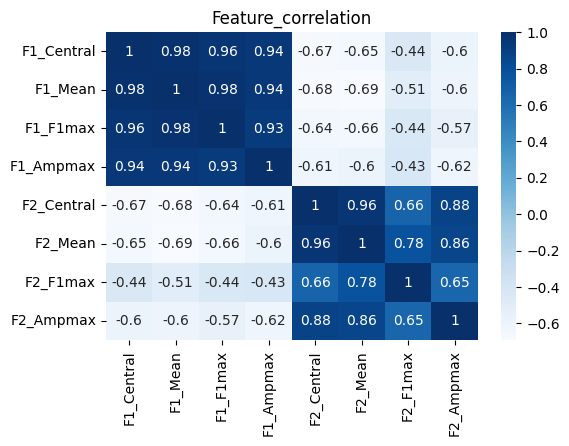

In [74]:
plt.figure(figsize=(6,4))
sns.heatmap((df.drop(columns= 'Label')).corr(), annot = True, cmap = 'Blues')
plt.title('Feature_correlation')
plt.show()

In [81]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]
feat_names = df.columns[0:-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, shuffle = True, random_state = 42)
model_dt = DecisionTreeClassifier(random_state = 42, max_depth = 4)
model_dt.fit(X_train, y_train) 
rules = export_text(model_dt, feature_names=feat_names)
print(rules)



|--- F1_Central <= 463.50
|   |--- class: I
|--- F1_Central >  463.50
|   |--- class: E



In [82]:
from sklearn.neural_network import MLPClassifier
import numpy as np
y = np.where(df['Label'] == 'I', 1, 0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_MLP = MLPClassifier(hidden_layer_sizes = (8,))
model_MLP.fit(X_train_scaled, y_train)
y_pred_MLP = model_MLP.predict(X_test_scaled)
acc_score = accuracy_score(y_test, y_pred_MLP)
print(f'The accuracy score is {acc_score:.2f}')


The accuracy score is 0.97


C:\Users\kalai\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [83]:
classification_report(y_test, y_pred_MLP, output_dict= True)


{'E': {'precision': 0.9814814814814815,
  'recall': 0.9636363636363636,
  'f1-score': 0.9724770642201835,
  'support': 55.0},
 'I': {'precision': 0.9615384615384616,
  'recall': 0.9803921568627451,
  'f1-score': 0.970873786407767,
  'support': 51.0},
 'accuracy': 0.9716981132075472,
 'macro avg': {'precision': 0.9715099715099715,
  'recall': 0.9720142602495543,
  'f1-score': 0.9716754253139752,
  'support': 106.0},
 'weighted avg': {'precision': 0.9718862549051228,
  'recall': 0.9716981132075472,
  'f1-score': 0.9717056758387378,
  'support': 106.0}}

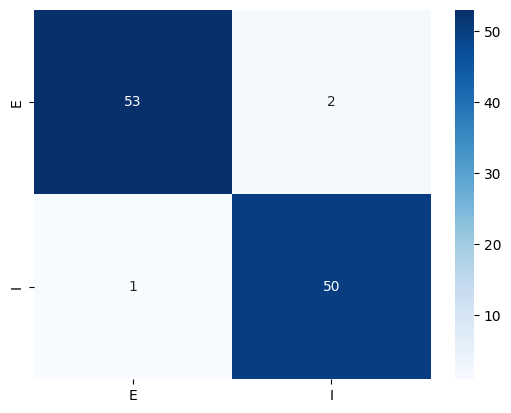

In [84]:
conf_MLP = confusion_matrix(y_test, y_pred_MLP)
sns.heatmap(conf_MLP, annot= True, xticklabels = model_MLP.classes_, yticklabels = model_MLP.classes_, cmap = 'Blues')
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

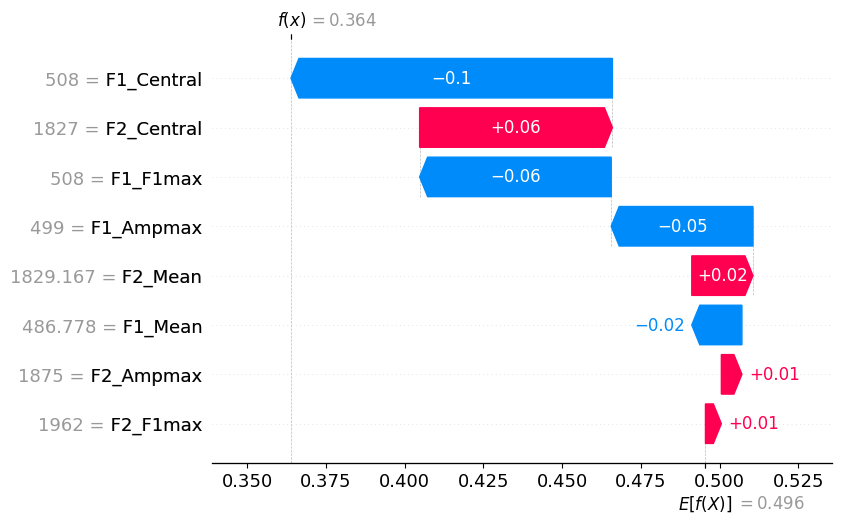

In [87]:
import shap
feat_names = df.columns[0:-1]
X = df[feat_names].astype(float)

# Function that restores column names before scaling
def f(x):
    x_df = pd.DataFrame(x, columns=feat_names)  
    x_scaled = scaler.transform(x_df)
    return model_MLP.predict_proba(x_scaled)[:, 1]  

background = shap.kmeans(X, 10)

explainer = shap.KernelExplainer(f, background)

instance = X.iloc[[1]]                 
sv = explainer.shap_values(instance)  
vals = sv.flatten()
base = explainer.expected_value

shap.waterfall_plot(shap.Explanation(
    values=vals,
    base_values=base,
    data=instance.iloc[0],
    feature_names=feat_names
))


  0%|          | 0/106 [00:00<?, ?it/s]

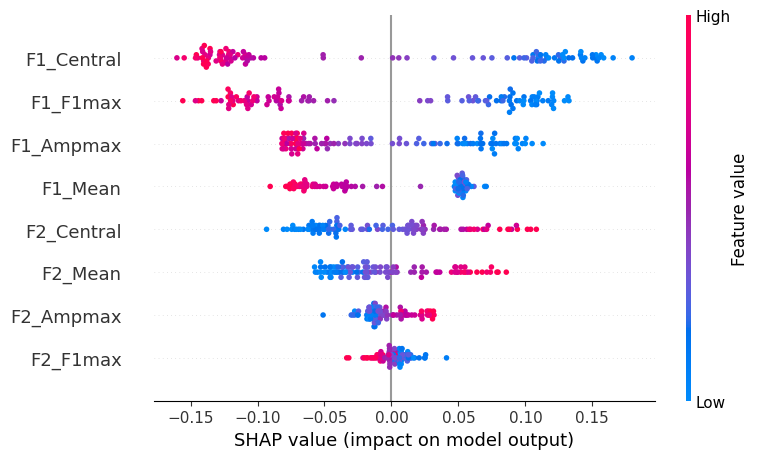

In [88]:

shap_values_all = explainer.shap_values(X_test)  

# Résumé global
shap.summary_plot(shap_values_all, X_test, feature_names=feat_names)


In [ ]:

from sklearn.model_selection import cross_val_score

strategies = {
    "Central":   ["F1_Central", "F2_Central"],
    "Mean":      ["F1_Mean", "F2_Mean"],
    "F1max":     ["F1_F1max", "F2_F1max"],
    "Ampmax":    ["F1_Ampmax", "F2_Ampmax"]
}

mlp_params = dict(hidden_layer_sizes=(8,), max_iter=2000, random_state=42)
logreg_params = dict(max_iter=2000, random_state=42)

for strat_name, cols in strategies.items():
    X = df[cols].values

    # Normalisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

  
    mlp = MLPClassifier(**mlp_params)
    logreg = LogisticRegression(**logreg_params)

    # Validation croisée (5 folds)
    acc_mlp = cross_val_score(mlp, X_scaled, y, cv=5, scoring='accuracy').mean()
    acc_log = cross_val_score(logreg, X_scaled, y, cv=5, scoring='accuracy').mean()

    print(f"--- {strat_name} ---")
    print(f"MLP Accuracy moyenne     : {acc_mlp:.3f}")
    print(f"Logistic Regression Acc. : {acc_log:.3f}")
    print()


--- Central ---
MLP Accuracy moyenne     : 0.994
Logistic Regression Acc. : 0.997

--- Mean ---
MLP Accuracy moyenne     : 0.994
Logistic Regression Acc. : 0.991

--- F1max ---
MLP Accuracy moyenne     : 0.981
Logistic Regression Acc. : 0.981

--- Ampmax ---
MLP Accuracy moyenne     : 0.931
Logistic Regression Acc. : 0.931

